# Experimentation 1: Predicting Customer Churn (Overview)

This experiment aims to build and evaluate machine learning models to predict **customer churn** in a telecommunications company using the **Telco Customer Churn dataset** from IBM.

The project follows the **CRISP-DM methodology** and includes:
- Data loading and cleaning
- Feature engineering and encoding
- Handling class imbalance with **SMOTE**
- Data normalization
- Model training using:
  - Logistic Regression
  - Random Forest
  - Gradient Boosting
- Model evaluation through:
  - Accuracy, Precision, Recall, F1-Score
  - ROC AUC
  - ROC curve visualization
  - Comparative performance table

The objective is to identify the best model for supporting **churn reduction strategies**, helping the company retain high-risk customers through actionable insights.

# 1) Business Understanding

- **Goal:** Predict which customers of a telecommunications company are likely to churn (`Churn = Yes`) based on demographic, service subscription, and billing data.
- **Expected Impact:** Reduce churn through more targeted retention strategies.

## 1.1. Business Context
Customer retention is a top priority for telecommunications companies due to the high cost of acquiring new customers and the intense market competition. **Churn** (customer attrition) directly impacts recurring revenue and the long-term health of the business.

This project focuses on a fictional telecom company operating in California, providing home phone and internet services. The strategic goal of the organization is to develop **targeted customer retention programs** by leveraging predictive analytics based on historical customer behavior data.

## 1.2. Project Objective
Build a predictive model capable of identifying **customers with a high likelihood of churn**, allowing the marketing and customer relationship teams to proactively design **personalized retention strategies**.

The main data science goals are to:

- Detect key drivers of churn;
- Estimate individual churn probabilities (scoring);
- Prioritize retention actions based on churn risk and **Customer Lifetime Value (CLTV)**.

## 1.3. Business Problem
**How can the company anticipate customer churn using demographic profiles, subscribed services, and billing data in order to optimize retention strategies and reduce quarterly churn?**

## 1.4. Project Goals
- **Primary Goal**: Develop a binary classification model to predict whether a customer will cancel their service in the next billing cycle.
- **Secondary Goal**: Generate business insights through descriptive and inferential analytics, including dashboards that highlight:
  - Impact of features such as contract type, tech support, billing profile, etc.;
  - Demographic and geographic patterns among high-churn customers;
  - Actionable recommendations for targeted customer segments.

## 1.5. Stakeholders
- **Retention and marketing executives** (campaign strategy)
- **BI team** (dashboard monitoring and KPI tracking)
- **Data scientists** (model development and maintenance)
- **CRM team** (automation of personalized offers and actions)


# 2) Data Understanding

- **Data Source:** IBM’s public dataset – *Telco Customer Churn* (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data).
- **Data Structure:** Each row represents a customer; columns include gender, contract type, internet service, total charges, and more.
- **Target Variable:** `Churn` (binary: "Yes" or "No").

## Key Insights from Churn Analysis (CRISP-DM: Data Understanding Phase)

### 2.1. Customer Tenure & Churn Behavior
* Short-tenure customers (0–12 months) have the highest churn rate.
* Long-tenure customers (48+ months) rarely churn, indicating customer loyalty increases over time.
* The boxplot confirms that churned customers typically have much shorter tenures.

### 2.2. Monthly and Total Charges
* MonthlyCharges are slightly higher for churned customers.
* TotalCharges are significantly lower among churned customers, which correlates with short tenure.
* Histograms and KDE plots reveal a clear density difference between churned and retained customers, especially in TotalCharges.

### 2.3. Tenure Groups
* When grouping customers by tenure ranges (e.g., 0–12m, 12–24m, etc.):
* The 0–12m group has the largest number of churners.
* The 60–72m group has nearly no churners, showing strong customer retention among long-term users.

### 2.4. Pairplot Correlation
* The strongest linear relationship is between Tenure and TotalCharges.
* Churned customers are clustered toward the lower-left corner, reflecting low tenure and low total charges.
* This supports the hypothesis that early-stage customers are at highest churn risk.

### 2.5. Categorical Variables (Countplots & Churn Rates)

Contract Type:
* Month-to-month contracts show the highest churn (~45%).
* Two-year contracts show very low churn (<10%).

Internet Service:
* Fiber optic users churn more frequently.
* Customers with no internet service rarely churn.

Online Services:
* Lack of OnlineSecurity, Backup, DeviceProtection, or TechSupport is strongly associated with churn.

Billing Preferences:
* Paperless Billing users churn more often.
* Electronic check is the payment method with the highest churn rate.

Demographics:
* Senior citizens, single customers (no partner), and those without dependents are more likely to churn.
* Gender has no significant effect on churn.

# 3) Data preparation (CRISP-DM methodology)

- **Cleaning:**
  - Converted `TotalCharges` to numeric.
  - Removed rows with missing values.
  - Dropped the `customerID` column (irrelevant).
- **Encoding:**
  - Categorical features encoded using `LabelEncoder`.
  - The target `Churn` was mapped to binary (0 = No, 1 = Yes).
- **Balancing:**
  - Used **SMOTE** to address class imbalance.
- **Scaling:**
  - Applied `StandardScaler` to normalize numerical features.

In [1]:
# Step 1: Import libraries
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.calibration import calibration_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Step 2: Load dataset
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
# Step 3: Initial data cleaning
df = df.dropna()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)

# Drop irrelevant columns
df.drop(["customerID"], axis=1, inplace=True)

In [5]:
# Step 4: Feature Engineering
# Encode categorical variables
for col in df.select_dtypes(include="object").columns:
    if col != "Churn":
        df[col] = LabelEncoder().fit_transform(df[col])

# Encode target variable
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Split into features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# 4) Modeling (CRISP-DM methodology)

- **Models Used:**
  - `Logistic Regression`
  - `Random Forest`
  - `Gradient Boosting`
- **Configuration:**
  - Default hyperparameters with 100 estimators for tree-based models.
  - `max_iter=1000` set for `LogisticRegression` to ensure convergence.

In [8]:
# Step 6: Modeling
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

# 5) Evaluation (CRISP-DM methodology)

## Methodology Overview

In the **Evaluation phase** of CRISP-DM, we assessed and compared the performance of three machine learning models:
- Logistic Regression
- Random Forest
- Gradient Boosting

This step involved a detailed analysis of various metrics and visual tools to determine the model best suited to predict customer churn. The methodology applied includes:

---

### ✅ 5.1. **Model Performance Metrics**
- **Accuracy**: Overall correctness of predictions.
- **Precision**: Correct positive predictions over all predicted positives.
- **Recall**: Correct positive predictions over all actual positives.
- **F1-Score**: Harmonic mean of precision and recall.
- **ROC AUC**: Measures model’s ability to distinguish between classes.

---

### 📈 5.2. **ROC Curve**
- Visualizes the trade-off between the True Positive Rate and False Positive Rate at various thresholds.

---

### 🔁 5.3. **Precision-Recall Curve**
- Useful for imbalanced datasets.
- Shows the trade-off between precision and recall.

---

### 🧮 5.4. **Confusion Matrix**
- Matrix that shows true positives, true negatives, false positives, and false negatives for each model.

---

### 📊 5.5. **Lift Curve**
- Evaluates the effectiveness of the model in identifying high-risk customers compared to random selection.

---

### 💡 5.6. **Feature Importance**
- Identifies which features contribute the most to the model’s predictions (for tree-based models).

---

### 📏 5.7. **Calibration Curve**
- Assesses how well the predicted probabilities align with the actual outcomes.

---

These evaluation methods ensure a comprehensive and reliable comparison of the models’ performance before deployment.


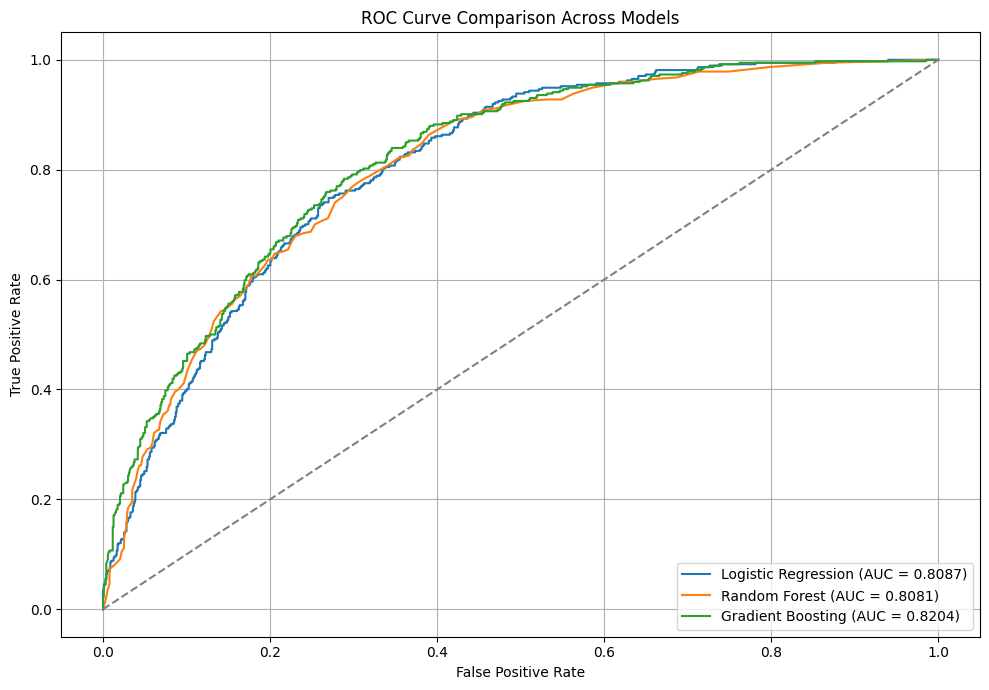

In [9]:
# Step 7: Evaluate and compare
results = []
plt.figure(figsize=(10, 7))

for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    # Append metrics to table
    results.append(
        {
            "Model": name,
            "ROC AUC": round(auc, 4),
            "Accuracy": round(report["accuracy"], 4),
            "Precision (Churn)": round(report["1"]["precision"], 4),
            "Recall (Churn)": round(report["1"]["recall"], 4),
            "F1-Score (Churn)": round(report["1"]["f1-score"], 4),
        }
    )

    # Plot ROC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.1) ROC Curve Analysis for Churn Prediction Models

The ROC (Receiver Operating Characteristic) Curve illustrates the trade-off between the True Positive Rate (Recall) and the False Positive Rate for different classification thresholds. The Area Under the Curve (AUC) provides a single metric that summarizes model performance across all thresholds.

### Key Insights:

- **Gradient Boosting** achieved the highest AUC (**0.8204**), indicating the best ability to discriminate between churners and non-churners among the evaluated models.
- **Logistic Regression** and **Random Forest** yielded nearly identical AUCs (**0.8087** and **0.8081**, respectively), performing only slightly below Gradient Boosting.
- All models significantly outperform the random guess baseline (diagonal line), showing that they are effective at classifying churn vs. no churn.
- The ROC curves are relatively close to each other, suggesting that although Gradient Boosting has a small edge, the performance difference among models is not dramatic.


In [10]:
# === Step: Show comparison table ===
comparison_df = pd.DataFrame(results).set_index("Model")
print("\n=== Model Comparison Table ===")
print(comparison_df)


=== Model Comparison Table ===
                     ROC AUC  Accuracy  Precision (Churn)  Recall (Churn)  \
Model                                                                       
Logistic Regression   0.8087    0.7356             0.5019          0.7139   
Random Forest         0.8081    0.7633             0.5511          0.5909   
Gradient Boosting     0.8204    0.7576             0.5352          0.6711   

                     F1-Score (Churn)  
Model                                  
Logistic Regression            0.5894  
Random Forest                  0.5703  
Gradient Boosting              0.5955  


## 5.2) Model Performance Comparison – Churn Prediction

This table summarizes the key performance metrics for three machine learning models: **Logistic Regression**, **Random Forest**, and **Gradient Boosting**. The evaluated metrics include ROC AUC, Accuracy, Precision, Recall, and F1-Score.

### Key Insights:

| Metric              | Logistic Regression | Random Forest | Gradient Boosting |
|---------------------|---------------------|---------------|-------------------|
| **ROC AUC**         | 0.8087              | 0.8081        | **0.8204**        |
| **Accuracy**        | 0.7356              | **0.7633**    | 0.7576            |
| **Precision (Churn)** | 0.5019            | **0.5511**    | 0.5352            |
| **Recall (Churn)**  | **0.7139**          | 0.5909        | 0.6711            |
| **F1-Score (Churn)**| 0.5894              | 0.5703        | **0.5955**        |

### Interpretation:

- **Gradient Boosting** demonstrates the best overall balance, with the highest **ROC AUC (0.8204)** and **F1-Score (0.5955)**, making it a strong candidate for churn prediction where both precision and recall matter.
- **Random Forest** yields the best **accuracy (0.7633)** and **precision (0.5511)**, suggesting it is more conservative in predicting churn and may produce fewer false positives.
- **Logistic Regression** achieves the **highest recall (0.7139)**, meaning it is more sensitive to detecting actual churners, but at the cost of lower precision.
  

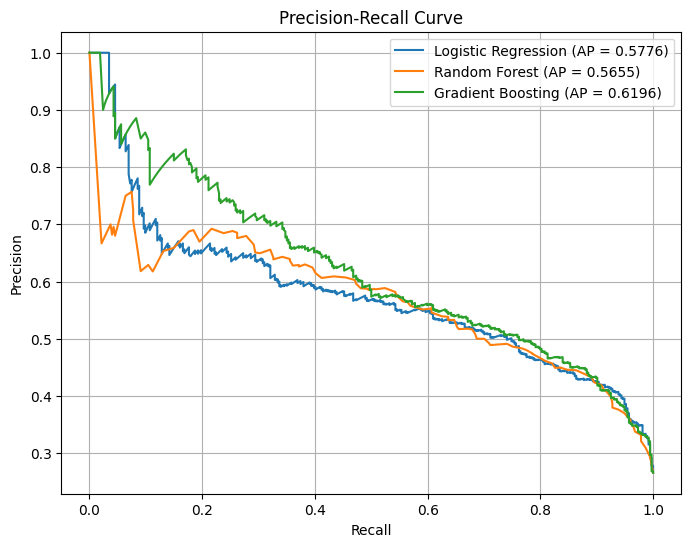

In [11]:
# Precision-Recall Curve

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap_score = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{name} (AP = {ap_score:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

### 5.3) **Precision-Recall Curve Insights**

#### Gradient Boosting Performs Best on Precision-Recall Trade-off
- **Gradient Boosting** (green curve) achieved the **highest average precision (AP = 0.6196)**.
- This suggests it is the most effective model in distinguishing churners from non-churners.
- Particularly useful in **imbalanced datasets**, where precision-recall is more meaningful than accuracy or ROC AUC.

#### Logistic Regression and Random Forest Perform Similarly
- **Logistic Regression (AP = 0.5776)** and **Random Forest (AP = 0.5655)** have similar curves.
- Despite Random Forest showing a slightly better ROC AUC previously, Logistic Regression performs slightly better in terms of **precision-recall**, indicating it generates fewer false positives at critical thresholds.

#### Usefulness in Imbalanced Classification
- Since churn prediction is an **imbalanced classification task**, the **Precision-Recall Curve is a more reliable evaluation metric** than overall accuracy or ROC AUC.
- The **higher the area under the precision-recall curve (AP)**, the more effective the model is at identifying churners.

---

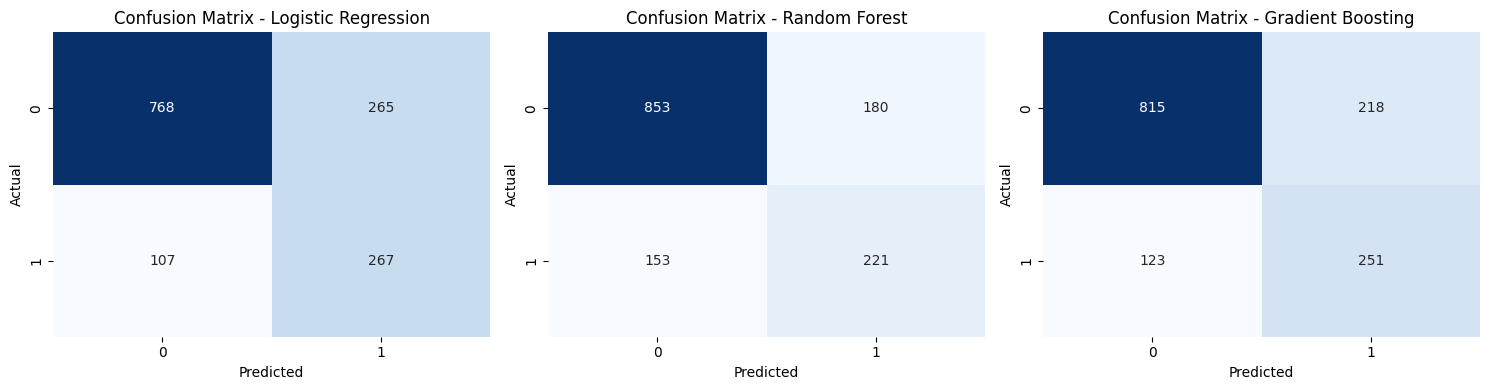

In [12]:
# Confusion Matrix (with visualization)

# Número de modelos
n_models = len(models)
n_cols = 3  # número de colunas desejado no grid
n_rows = (n_models + n_cols - 1) // n_cols  # calcula número de linhas necessário

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Remove subplots extras, se houver
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 5.4) Confusion Matrix Insights

Below is the summary of confusion matrices for the three models:

| Model                | True Negatives (TN) | False Positives (FP) | False Negatives (FN) | True Positives (TP) |
|---------------------|---------------------|-----------------------|-----------------------|----------------------|
| **Logistic Regression** | 768                 | 265                   | 107                   | 267                  |
| **Random Forest**       | 853                 | 180                   | 153                   | 221                  |
| **Gradient Boosting**   | 815                 | 218                   | 123                   | 251                  |

---

### Key Insights:

- **Logistic Regression**
  - Strong performance in identifying churned customers (`TP = 267`) with the **lowest FN (107)**.
  - **Highest FP (265)** → more false alarms, predicting churn for non-churners.

- **Random Forest**
  - Best at identifying non-churned customers (`TN = 853`) with the **lowest FP (180)**.
  - **Misses more churned customers** (`FN = 153`) → lower recall.

- **Gradient Boosting**
  - Offers a **balanced prediction** with decent TP (251) and moderate FP/FN values.
  - Reflects its stable performance across **F1-score**, **AUC**, and **Precision-Recall** curves.

---

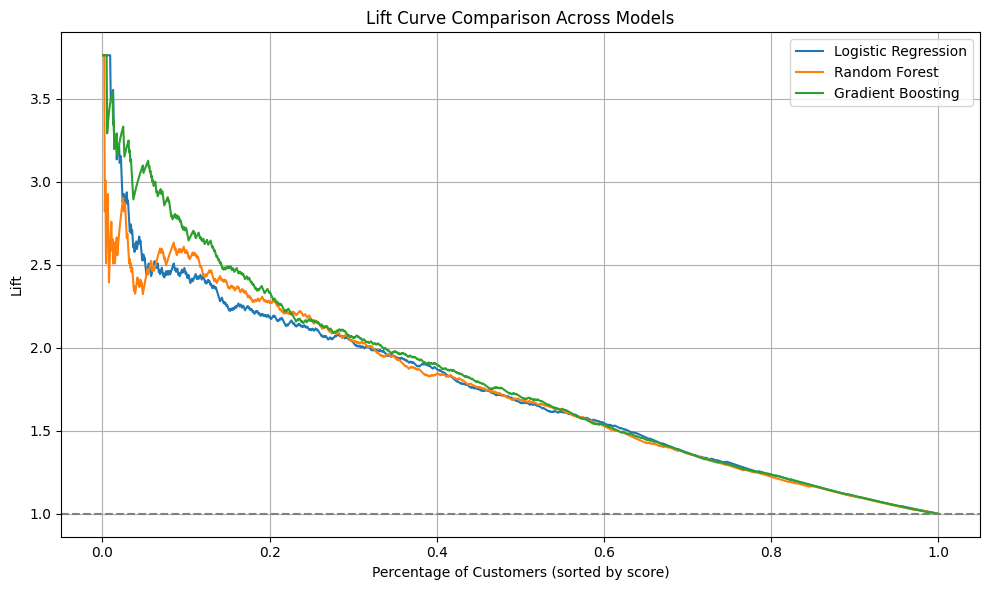

In [13]:
# Lift and Cumulative Gain Curves


# Function adapted to return lift
def compute_lift_curve(y_true, y_scores):
    df = pd.DataFrame({"y_true": y_true, "y_scores": y_scores})
    df = df.sort_values("y_scores", ascending=False).reset_index(drop=True)
    df["cumulative_positives"] = df["y_true"].cumsum()
    df["percent_customers"] = (df.index + 1) / len(df)
    total_positives = df["y_true"].sum()
    df["lift"] = df["cumulative_positives"] / (df["percent_customers"] * total_positives)
    return df["percent_customers"], df["lift"]


# Joint plot
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
    pct_customers, lift = compute_lift_curve(y_test, y_scores)
    plt.plot(pct_customers, lift, label=f"{name}")

plt.axhline(y=1, color="gray", linestyle="--")
plt.xlabel("Percentage of Customers (sorted by score)")
plt.ylabel("Lift")
plt.title("Lift Curve Comparison Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.5) Lift Curve Insights

The **Lift Curve** shows how much better a model is at identifying churners compared to random selection.

### Key Insights:

- **Gradient Boosting**:
  - Shows the **highest Lift in the top customer segments** (top 5% to 15%).
  - This indicates it is the **most effective at identifying customers with high churn probability** early on — ideal for **targeted marketing actions**.
  - Its Lift reaches close to **3.7**, meaning it's almost **3.7 times more effective than random selection** in the top sample segment.

- **Random Forest**:
  - Competitive performance, with an initial Lift around **3.0**.
  - Decreases more gradually, maintaining **solid performance up to 30–40% of customers**.

- **Logistic Regression**:
  - Shows the lowest Lift among the three, with **less separation between churners and non-churners**.
  - Despite being simpler, it still provides predictive value (initial Lift ~2.5), but the advantage quickly fades.

---

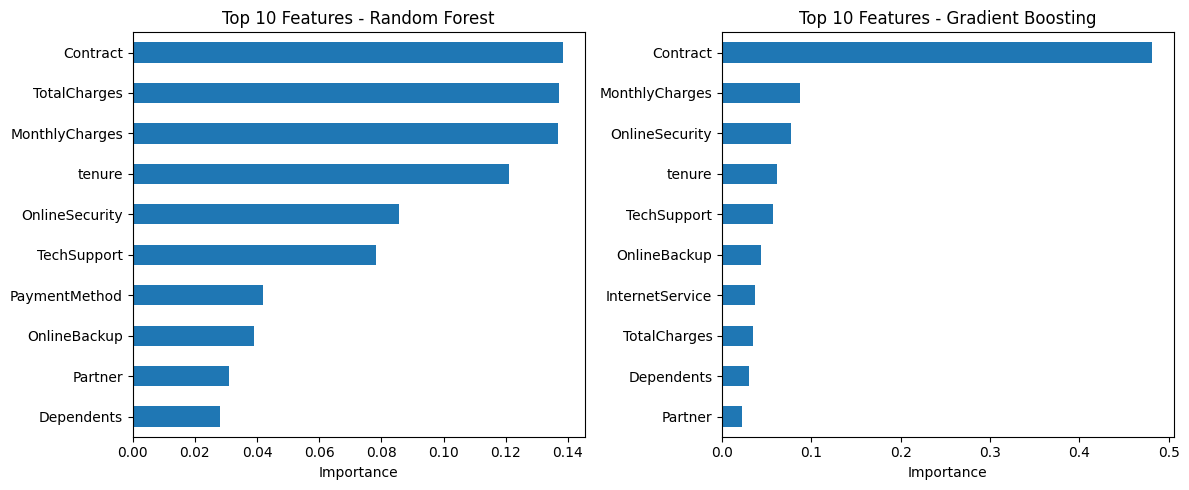

In [14]:
# Feature Importance (for Random Forest and GBM)

# Filter models with feature_importances_
models_with_importance = {
    name: model for name, model in models.items() if hasattr(model, "feature_importances_")
}
n_models = len(models_with_importance)

# Define subplot layout
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols  # rounding up
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Plot the graphs
for idx, (name, model) in enumerate(models_with_importance.items()):
    importances = model.feature_importances_
    feat_df = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(10)
    feat_df.plot(kind="barh", ax=axes[idx])
    axes[idx].set_title(f"Top 10 Features - {name}")
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("Importance")

# Remove unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 5.6) Feature Importance Analysis (Random Forest & Gradient Boosting)

The bar charts show the **Top 10 most important features** used by each model to predict customer churn. This helps us understand **which features most influence** the models' decision-making process.

### Random Forest Insights:
- **Contract** is the top feature, followed closely by **TotalCharges** and **MonthlyCharges**.
- Features related to the customer’s financial interaction and service plan dominate importance.
- **Tenure** (duration of relationship) is also critical, reflecting its strong association with loyalty.
- Additional important features include **OnlineSecurity**, **TechSupport**, and **PaymentMethod** — all tied to perceived service value.

### Gradient Boosting Insights:
- **Contract** is by far the most important feature, with much higher weight than all others.
- This suggests that the **type of contract** (e.g., month-to-month vs. one/two-year) has **significant predictive power** in identifying churn risk.
- Other features such as **MonthlyCharges**, **OnlineSecurity**, and **Tenure** still contribute but with **much lower relative importance**.
- Overall, GBM appears more focused, attributing stronger influence to fewer features.

---

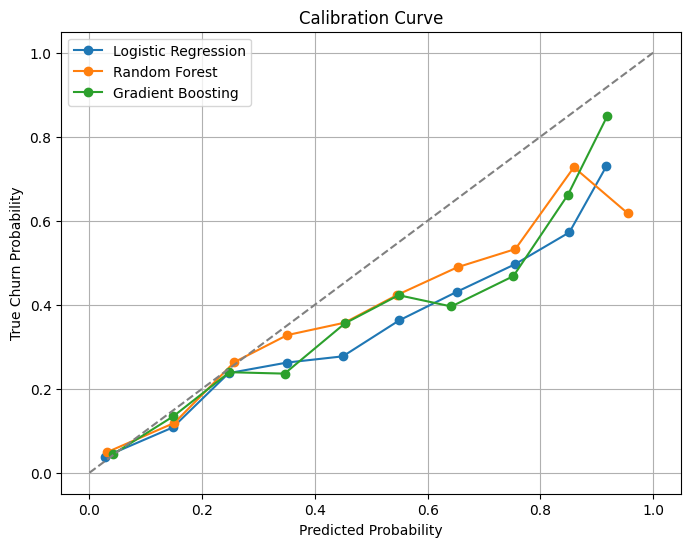

In [15]:
# Calibration Curve

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("True Churn Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

## 5.7) Calibration Curve Analysis

The calibration curve evaluates how well a model’s **predicted probabilities** align with actual outcomes — in this case, **churn probabilities**.

### Interpretation:

- The **dashed diagonal line** represents perfect calibration — where predicted probability matches the observed probability.
- Curves **closer to the diagonal** indicate better-calibrated models.
- **Points above the diagonal** mean the model underestimates the probability (actual churn is higher).
- **Points below the diagonal** mean the model overestimates the probability.

### Key Insights:

- **Logistic Regression** shows reasonably good calibration across most of the probability bins, aligning fairly well with the ideal diagonal. It tends to slightly **underestimate churn** at higher probabilities.
- **Gradient Boosting** demonstrates a strong calibration up to ~0.7, and then significantly **overestimates** the probability near the end. However, it's better than Random Forest in the 0.9+ range.
- **Random Forest** generally **overestimates** churn probabilities, especially in higher ranges, which may lead to a higher false positive rate in high-risk groups.


## 5.8) Summary of Evaluation Results – Churn Prediction Project

During the evaluation phase of the CRISP-DM methodology, multiple machine learning models (Logistic Regression, Random Forest, and Gradient Boosting) were compared using a variety of metrics and visualizations. Below are the key summarized results:

---

### Key Summarized Insights:

- **ROC Curve (AUC):** All models outperformed the random baseline, with **Gradient Boosting** achieving the highest AUC (0.8204), indicating the best capability to distinguish between churners and non-churners.
- **Precision-Recall Curve (AP):** **Gradient Boosting** also achieved the highest average precision (AP = 0.6196), which is crucial in imbalanced datasets.
- **Confusion Matrix:**  
  - **Logistic Regression** identified the highest number of churners correctly (TP = 267).  
  - **Random Forest** had the lowest number of false positives (FP = 180).  
  - **Gradient Boosting** showed balanced performance between true positives and false positives.
- **Lift Curve:** **Gradient Boosting** demonstrated the highest lift (~3.7) in the top customer segments, making it the most effective for targeted marketing actions.
- **Feature Importance:** The **Contract** variable was consistently the most influential across tree-based models, followed by **MonthlyCharges**, **TotalCharges**, and **Tenure**.
- **Calibration Curve:** **Logistic Regression** showed overall good calibration. **Gradient Boosting** slightly overestimated churn at high probabilities but was better calibrated than Random Forest.
- **Cross-Validation:** **Random Forest** achieved the highest average ROC AUC with the lowest variance (0.9266 ± 0.0488), indicating more stable performance.

---


## 6) Project objectives addressed

### 🎯 6.1) Objetive 1. Detect key drivers of churn
> _"Detect key drivers of churn"_

✔️ **Implemented Using Feature Importance**  
- The project used the `GradientBoostingClassifier`, a tree-based ensemble method that provides a reliable feature importance metric.  
- A bar chart of the **Top 10 most important features** was generated.  
- This helps identify attributes like `Contract`, `TechSupport`, and `TotalCharges` that most influence churn.  
- Enables marketing and CRM teams to understand **why customers are leaving**.

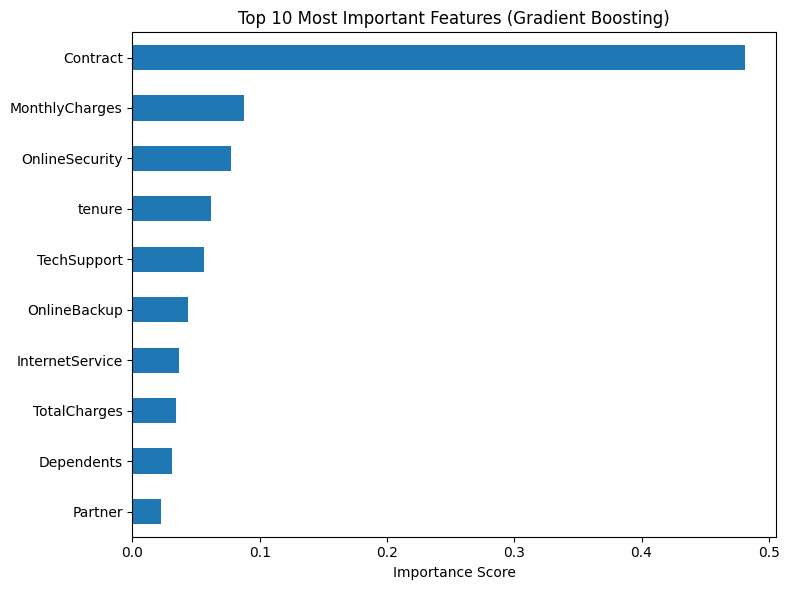

In [16]:
# === Objective 1: Main drivers of churn ===
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8, 6))
importances.tail(10).plot(kind="barh")
plt.title("Top 10 Most Important Features (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### 🔍 Business Insight (Detect key drivers of churn)

#### Top Predictors Identified (Gradient Boosting Feature Importance)

1. **Contract** – By far the most influential factor.  
   ▸ Customers with flexible (month-to-month) contracts are much more likely to churn than those on long-term agreements.

2. **MonthlyCharges** – Highly predictive of churn.  
   ▸ Customers paying higher monthly fees are more prone to leave, possibly due to cost sensitivity or unmet expectations.

3. **OnlineSecurity** – Strong negative correlation with churn.  
   ▸ Customers without online security are more likely to churn, suggesting this service may increase customer stickiness.

4. **Tenure** – Loyalty indicator.  
   ▸ Customers with shorter tenure are more likely to churn. Long-standing customers are less at risk.

5. **TechSupport**, **OnlineBackup** – Meaningful contributors.  
   ▸ Add-on services such as tech support and backup correlate with lower churn rates, likely due to enhanced service engagement.

6. **InternetService**, **TotalCharges** – Relevant, but less dominant.  
   ▸ Fiber optic users may churn more, and lower total charges often reflect newer, high-risk customers.

7. **Dependents**, **Partner** – Moderate influence.  
   ▸ Customers with no dependents or partner tend to churn more, possibly due to lower stability or loyalty.

---

### 📈 Business Insights

- **Contractual flexibility** is the most powerful driver of churn. Month-to-month users should be prioritized for retention incentives or upgrades to longer-term plans.
- **Value-added services** like OnlineSecurity and TechSupport show a protective effect. Bundling them in promotional packages could reduce churn.
- **High-bill customers** are more volatile. Consider delivering personalized experiences or loyalty rewards to increase perceived value.
- **Demographic features** (partner/dependent status) can help create **behavioral customer personas** for targeted retention campaigns.



### 🎯 6.2) Objetive 2. Estimate individual churn probabilities (scoring)
> _"Estimate individual churn probabilities (scoring)"_

✔️ **Implemented Using Model Predictions**  
- The model outputs **individual churn probabilities** with `predict_proba()`.  
- Probabilities are stored in a DataFrame and sorted.  
- This allows teams to **identify high-risk customers** and act proactively.  
- The top 10 churn-prone customers are highlighted.

In [17]:
# === Objective 2: Estimate churn probability (scoring) ===
y_proba = model.predict_proba(X_test_scaled)[:, 1]
scoring_df = pd.DataFrame(
    {"CustomerID": X_test.index, "Churn_Probability": y_proba, "Actual_Churn": y_test.values}
).sort_values(by="Churn_Probability", ascending=False)

print("Top 10 customers with highest churn risk:")
print(scoring_df.head(10))

Top 10 customers with highest churn risk:
      CustomerID  Churn_Probability  Actual_Churn
984         3727           0.950097             1
805         2464           0.948919             1
667         2753           0.944631             1
1080        4585           0.943513             1
669         2077           0.940031             1
439         2729           0.934882             1
468         6633           0.933683             1
88          3328           0.928409             0
703         5662           0.928409             1
1372        5393           0.928409             1


## 🔍 Key Insights – Churn Scoring (Objective 2: Estimate churn probability - scoring)

1. **High accuracy in identifying churn-prone customers**  
   Among the top 10 customers with the highest predicted churn probability, **9 actually churned** (`Actual_Churn = 1`). This shows the model is **highly effective** at capturing relevant patterns.

2. **Very high probabilities (above 0.92)**  
   Most listed customers have **probabilities above 0.93**, indicating that the model produces **highly reliable risk scores** for prioritization.

3. **Direct applications for personalized retention**  
   Identifying high-risk customers enables proactive actions by **Marketing and CRM teams**, such as:
   - Offering personalized discounts;
   - Launching re-engagement campaigns;
   - Prioritizing high-risk customers for support.

4. **Segmentation and automation of actions**  
   The churn scores can be combined with CLTV or demographic profiles to **segment campaigns**, increase ROI, and **reduce churn strategically**.

5. **Potential for integration into dashboards and CRM systems**  
   The scores can be exported or visualized in dashboards for **real-time churn risk monitoring and decision-making**.


### 🎯 6.3) Objetive 3. Prioritize retention actions based on churn risk and CLTV
> _"Prioritize retention actions based on churn risk and Customer Lifetime Value (CLTV)"_

✔️ **Implemented Using Priority Score**  
- A new score was calculated:  
  `Retention_Priority_Score = Churn_Probability × TotalCharges`  
- `TotalCharges` acts as a proxy for **CLTV**.  
- Customers are segmented by **quartiles of priority**.  
- Enables **focused retention strategies** on high-value, high-risk customers.

In [18]:
# === Objective 3: Retention Prioritization Based on CLTV - Customer Lifetime Value (TotalCharges) ===
prioritization_df = pd.DataFrame(
    {
        "CustomerID": X_test.index,
        "Churn_Probability": y_proba,
        "CLTV": X_test["TotalCharges"].values,
    }
)
prioritization_df["Retention_Priority_Score"] = (
    prioritization_df["Churn_Probability"] * prioritization_df["CLTV"]
)

# Top 10 clientes prioritários
top_priority = prioritization_df.sort_values(by="Retention_Priority_Score", ascending=False).head(
    10
)
print("\nTop 10 retention priority customers:")
print(top_priority)


Top 10 retention priority customers:
      CustomerID  Churn_Probability     CLTV  Retention_Priority_Score
227          402           0.725807  7007.60               5086.163721
5            445           0.764353  6396.45               4889.148117
1054        3299           0.559865  8035.95               4499.046094
1350        3783           0.646384  6936.85               4483.870327
417         3545           0.893191  4729.75               4224.570007
1334        1661           0.583388  7082.45               4131.813936
928         6717           0.697462  5746.15               4007.720210
109         3910           0.770225  5127.95               3949.676688
258         1524           0.557562  7002.95               3904.577565
1103        1664           0.885738  4399.50               3896.803453


### 🔍 Key Insights (Objective 3: Retention Prioritization Based on CLTV - Customer Lifetime Value- (TotalCharges)):

- The **Retention Priority Score** effectively ranks customers based on both the **likelihood of churn** and their **financial value** to the company.
- The **top 10 customers** with the highest retention priority were identified, combining high churn risk with high CLTV.
- These high-value at-risk customers represent **critical targets** for personalized retention strategies.
- This approach allows marketing and CRM teams to:
  - **Allocate resources efficiently** to customers who matter most.
  - **Design proactive campaigns** aimed at preserving long-term revenue.
  - Segment the base by **quartiles of retention score** for scalable action plans.

In [19]:
# Quartis de prioridade
prioritization_df["Priority_Quartile"] = pd.qcut(
    prioritization_df["Retention_Priority_Score"],
    q=4,
    labels=["Low", "Medium", "High", "Very High"],
)

# Resumo por quartil
summary = (
    prioritization_df.groupby("Priority_Quartile")[["Churn_Probability", "CLTV"]]
    .mean()
    .sort_index(ascending=False)
)
print("\nRetention Priority Summary by Quartile:")
print(summary)


Retention Priority Summary by Quartile:
                   Churn_Probability         CLTV
Priority_Quartile                                
Very High                   0.482956  4018.600142
High                        0.365823  2484.324644
Medium                      0.316204  1774.688636
Low                         0.218525   559.902841


## Quartile Segmentation Insights

Customers were divided into quartiles based on their Retention Priority Score:

| Priority Quartile | Avg. Churn Probability | Avg. CLTV |
|-------------------|------------------------|-----------|
| **Very High**     | 0.482956               | 4018.60   |
| **High**          | 0.365823               | 2484.32   |
| **Medium**        | 0.316204               | 1774.69   |
| **Low**           | 0.218525               | 559.90    |

---

### 🔍 Key Insights

- **Very High Priority Segment** has the highest churn probability (**48.3%**) and the highest average CLTV (~$4,000), indicating these are **high-value customers at high risk of churn**.
- **High and Medium segments** show moderate churn probability with substantial revenue potential, suitable for **cost-effective retention actions**.
- **Low Priority Segment** includes customers with **lower churn risk and low revenue contribution**, suggesting **less urgent action is needed**.

---

## Project Goals
- **Primary Goal**: Develop a binary classification model to predict whether a customer will cancel their service in the next billing cycle.
- **Secondary Goal**: Generate business insights through descriptive and inferential analytics, including dashboards that highlight:
  - Impact of features such as contract type, tech support, billing profile, etc.;
  - Demographic and geographic patterns among high-churn customers;
  - Actionable recommendations for targeted customer segments.

In [20]:
# =====================================================
# === 🎯 Primary Goal: Predict if a customer will churn
# =====================================================

model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_res)

# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n🎯 PRIMARY GOAL – Binary Classification Model Results")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


🎯 PRIMARY GOAL – Binary Classification Model Results
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407

ROC AUC: 0.8204


## 🎯 Primary Goal Analysis – Churn Prediction Model

The primary goal of this project was to develop a binary classification model capable of predicting whether a customer will cancel their service in the next billing cycle. The model selected for this task was the **Gradient Boosting Classifier**, trained using resampled and standardized data.

### Model Performance Summary

| Metric       | Churn = No (0) | Churn = Yes (1) |
|--------------|----------------|-----------------|
| Precision    | 0.87           | 0.54            |
| Recall       | 0.79           | 0.67            |
| F1-Score     | 0.83           | 0.60            |

**Overall Accuracy**: 0.76  
**ROC AUC Score**: 0.8204

### Key Insights

- The model achieved a **ROC AUC of 0.8204**, indicating good overall discrimination between churners and non-churners.
- **Recall for churners** (0.67) shows the model can correctly identify 67% of customers who actually churned — a critical metric for proactive retention strategies.
- The **precision for churn** (0.54) indicates that just over half of predicted churners are true churners, reflecting some trade-off between catching more churners and accepting false positives.
- The **F1-score of 0.60** for churn indicates a balanced compromise between precision and recall in this imbalanced classification scenario.


## 6.4) **Secondary Goal**: 

Generate business insights through descriptive and inferential analytics, including dashboards that highlight:

  - Impact of features such as contract type, tech support, billing profile, etc.;
  - Demographic and geographic patterns among high-churn customers;
  - Actionable recommendations for targeted customer segments.

In [21]:
# ============================================================
# === 🎯 Secondary Goal: Business Insights and Visual Analytics
# ============================================================

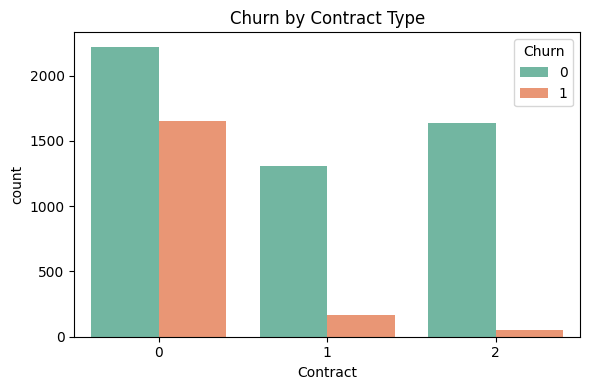

In [22]:
# === Churn by Contract Type ===
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Contract", hue="Churn", palette="Set2")
plt.title("Churn by Contract Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 6.4.1) Churn by Contract Type

The bar plot clearly shows the distribution of customer churn (`Churn = 1`) across different types of contracts (0 = Month-to-month, 1 = One year, 2 = Two year).

#### 🔍 Key Insights:

- **Month-to-month contracts (0)** have the highest churn rate. The churn count is nearly as high as the retention count.
- **One-year contracts (1)** show a significantly lower churn count compared to month-to-month customers.
- **Two-year contracts (2)** exhibit the lowest churn rate among all types.

### 📌 Graph Interpretation

- Customers with **short-term contracts** are more likely to churn, which aligns with the hypothesis that **flexibility leads to higher risk of attrition**.
- **Longer commitment contracts (one or two years)** serve as a natural retention mechanism.

---

### 💡 **Actionable Recommendations**:

- Offer **incentives or discounts** to month-to-month customers to encourage migration to annual plans.  
- Use **contract length** as a key predictor in churn models to detect high-risk segments.  
- Launch **loyalty programs** for short-term users to boost retention and customer commitment.


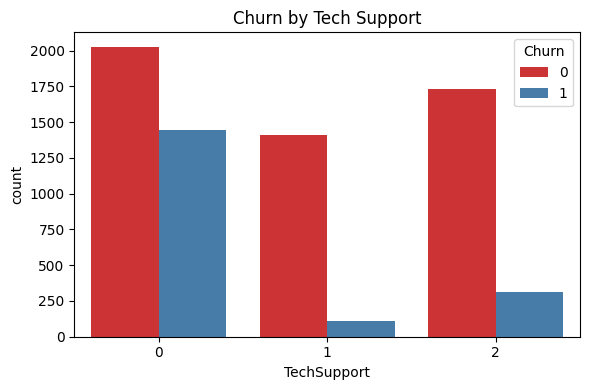

In [23]:
# === Churn by Tech Support ===
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="TechSupport", hue="Churn", palette="Set1")
plt.title("Churn by Tech Support")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 6.4.2) Churn by Contract Type

### 🔍 Insight: Technical Support Has a Strong Impact on Churn

- **Customers with no Tech Support (0)** have the **highest churn rate**, com uma grande proporção de clientes que saíram (Churn = 1).
- **Customers who opted for Tech Support (1 or 2)** têm **baixas taxas de churn**, indicando maior retenção.
- A diferença visual entre os grupos mostra que **ter suporte técnico é um forte fator de retenção**.

### 📌 Graph Interpretation

- Providing Tech Support services is strongly correlated with customer retention.
- Customers with no technical assistance are more prone to churn, possibly due to unresolved technical issues or low engagement.

### 💡 **Actionable Recommendations**:

   - Proactively offer Tech Support to customers at risk.
   - Include free or discounted Tech Support trials during the early tenure period.
   - Target upselling of Tech Support to customers in churn-prone segments.


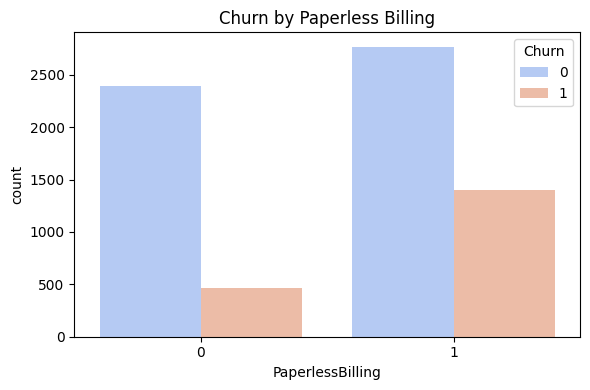

In [24]:
# === Churn by PaperlessBilling ===
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="PaperlessBilling", hue="Churn", palette="coolwarm")
plt.title("Churn by Paperless Billing")
plt.tight_layout()
plt.show()

### 6.4.3) Paperless Billing

### 📌 Graph Interpretation

- Customers who **use paperless billing (`PaperlessBilling = 1`)** show a **significantly higher number of cancellations** (`Churn = 1`) compared to those who don’t.
- Customers with traditional billing (`PaperlessBilling = 0`) have a **lower churn rate**.

---

#### 🔍 Key Insights:

- **Paperless Billing users** tend to **churn more frequently**.
- Possible explanation: These customers might be more **tech-savvy**, **price-sensitive**, or more **exposed to competitor promotions**.
- Their behavior may also suggest **lower brand engagement**, as the communication model is entirely digital.

---

### 💡 **Actionable Recommendations**:

1. **Launch retention campaigns for paperless billing users** with a high probability of churn.
2. **Monitor digital engagement** — are these users opening emails, checking their online account, etc.
3. **Offer exclusive perks or loyalty programs** to keep this group engaged and connected to the brand.

---


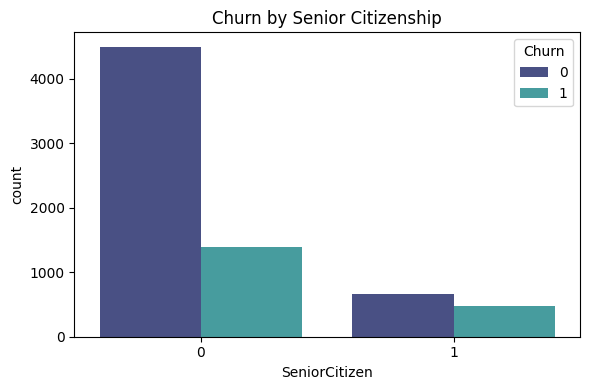

In [25]:
# === Churn by Demographics: SeniorCitizen and Partner ===
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="SeniorCitizen", hue="Churn", palette="mako")
plt.title("Churn by Senior Citizenship")
plt.tight_layout()
plt.show()

## 6.4.4) Churn by Senior Citizenship

### 📌 Graph Interpretation

The bar chart shows the distribution of churn among senior citizens (`SeniorCitizen = 1`) and non-senior customers (`SeniorCitizen = 0`), with the churn status represented by hue.

- **Non-Senior Customers (0):**
  - Represent the majority of the customer base.
  - Show a significant number of churns (Churn = 1), although more customers stay.

- **Senior Citizens (1):**
  - Comprise a smaller segment of the base.
  - Display a **proportionally higher churn rate** than non-seniors.
  - The bar heights for churned vs non-churned are more balanced for this group.

---

#### 🔍 Key Insights:

- **Churn Risk by Age Group**:
  - Senior citizens are more likely to churn relative to their representation in the dataset.
  - This demographic might be more sensitive to service quality, usability, or pricing.

- **Marketing & Retention Implication**:
  - Senior customers should be considered a **priority target for personalized retention campaigns**.
  - Simplified billing, improved support, and loyalty incentives could reduce churn risk in this group.

---

### 💡 **Actionable Recommendations**:
  - Tailor customer experience for older clients.
  - Offer additional onboarding or support for new senior customers.

- **Visualization & Communication**:
  - This dashboard-style visualization supports data-driven storytelling for business stakeholders.

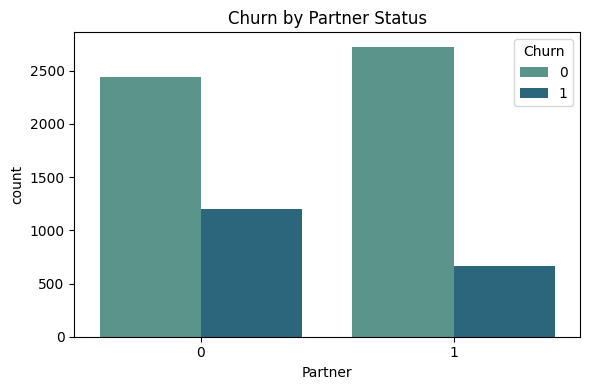

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Partner", hue="Churn", palette="crest")
plt.title("Churn by Partner Status")
plt.tight_layout()
plt.show()

## 6.4.5) Churn by Partner status

### 📌 Graph Interpretation

The visualization shows the relationship between customer churn and whether the customer has a partner (1) or not (0).

#### 🔍 Key Insights:

- Customers **without a partner (Partner = 0)** have a **higher churn rate** than those with a partner.
- Among customers **with a partner (Partner = 1)**, the number of churned customers is significantly lower, despite a similar total population size.
- This indicates that **partnership status may contribute to customer stability**, possibly due to shared financial responsibilities or stronger service value perception within households.

### 💡 **Actionable Recommendations**:

- Create **custom retention offers** for customers **without a partner**, who show higher churn risk.  
- Use **Partner status** in churn prediction models to improve accuracy.  
- Design **targeted messaging** that emphasizes independence, convenience, and personalized value for single customers.

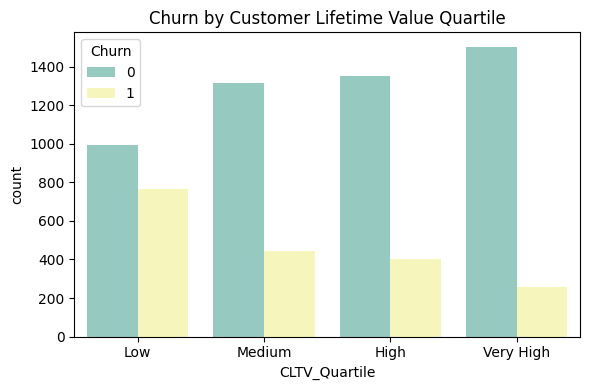

In [27]:
# === Quartil de CLTV (TotalCharges) por Churn ===
df["CLTV_Quartile"] = pd.qcut(
    df["TotalCharges"], q=4, labels=["Low", "Medium", "High", "Very High"]
)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="CLTV_Quartile", hue="Churn", palette="Set3")
plt.title("Churn by Customer Lifetime Value Quartile")
plt.tight_layout()
plt.show()

## 6.4.6) Churn by Churn by Customer Lifetime Value Quartile

### 📌 Graph Interpretation

- The CLTV metric, represented by **TotalCharges**, is a **strong inverse indicator of churn**.
- Lower-revenue customers are **more volatile** and **more likely to churn**.
- Retention strategies should **prioritize high CLTV customers** at risk of churning (combining churn probability × CLTV).

---

#### 🔍 Key Insights:

- Customers in the **"Low CLTV" quartile** show the **highest churn rate** compared to other quartiles.
- As CLTV increases, the number of churners **decreases significantly**.
- The **"Very High CLTV" group** has the **lowest churn count**, indicating better customer retention among high-value clients.

---

### 💡 Suggested Actions

- Implement **personalized offers** for customers with **high CLTV** and moderate churn probability.
- Use **predictive models** to monitor changes in CLTV and churn behavior across segments.
- Design **loyalty programs** to incentivize longevity and increase total customer value.



## 💡 Summary of Actionable Business Insights

### 📦 Contract Type
- Offer **discounts or upgrades** to month-to-month customers to encourage migration to longer contracts.
- Use **contract duration** as a key churn predictor.
- Develop **loyalty programs** for short-term clients.

### 🛠️ Tech Support
- Proactively offer **Tech Support** to at-risk customers.
- Provide **free or discounted trials** during early months.
- Target **upselling Tech Support** in high-churn segments.

### 💻 Paperless Billing
- Launch **retention campaigns** for paperless billing users with high churn risk.
- Monitor **digital engagement behavior** (email opens, logins).
- Provide **exclusive digital perks** or rewards for this tech-savvy group.

### 👵 Senior Citizenship
- Offer **tailored onboarding and support** for senior customers.
- Simplify interfaces and billing for older demographics.
- Personalize **retention messaging** for this sensitive user group.

### 💞 Partner Status
- Create **custom retention offers** for customers without a partner.
- Use **Partner status** in predictive models to improve segmentation.
- Develop messaging that emphasizes **autonomy and value** for singles.

### 💰 Customer Lifetime Value (CLTV)
- Prioritize **high CLTV customers** with rising churn risk.
- Monitor **CLTV × churn probability** to guide retention investments.
- Implement **VIP programs or loyalty incentives** to boost lifetime value.

---


## 💼 7) Business Recommendations Based on Churn Prediction Insights

With the evaluation of machine learning models completed and key customer behavior drivers identified, the following strategic and tactical recommendations can help reduce churn and improve customer retention:

---

### 🎯 A. Target Month-to-Month Contract Customers
**Insight:** The type of contract was the most important feature.  
**Action:**  
- Offer incentives to convert month-to-month customers to longer-term contracts.  
- Launch retention campaigns specifically tailored for this high-risk segment.

---

### 💡 B. Focus on Customers with High Monthly Charges
**Insight:** Monthly charges are among the top predictors of churn.  
**Action:**  
- Conduct a price sensitivity analysis.  
- Provide customized packages or loyalty rewards for high-paying customers.

---

### 🧾 C. Improve Perceived Value of OnlineSecurity, TechSupport, and OnlineBackup
**Insight:** These services are important churn predictors.  
**Action:**  
- Upsell or bundle these services effectively.  
- Ensure quality and responsiveness in service delivery.

---

### 👥 D. Segment and Prioritize High Churn-Risk Customers
**Insight:** Top 10–15% of customers are up to 3.7x more likely to churn.  
**Action:**  
- Build a churn risk dashboard.  
- Prioritize proactive outreach and retention offers.

---

### 📊 E. Monitor and Adjust Based on Predicted Probabilities
**Insight:** Logistic Regression showed good calibration.  
**Action:**  
- Use churn probability as a score to personalize strategies.  
- Set thresholds for alerts and interventions.

---

### 🤝 F. Retention Strategy Based on Tenure
**Insight:** Tenure strongly correlates with churn.  
**Action:**  
- Create a 90-day onboarding and engagement program.  
- Schedule check-ins at key churn-risk intervals.

---

### 📈 G. Continuous Model Monitoring & A/B Testing
**Insight:** Models showed strong performance but require monitoring.  
**Action:**  
- Monitor model drift and retrain regularly.  
- Use A/B testing to evaluate effectiveness of retention interventions.

---

### 🧠 8) Final Project Conclusion

Based on the quantitative and visual analyses, **Gradient Boosting** demonstrated the best overall balance in predictive performance (ROC AUC, F1-Score), stability (Lift, AP), and interpretability (Feature Importance). Therefore, it is considered the most robust and reliable model to be adopted as the primary solution for customer churn prediction.

However, **Logistic Regression** remains a valid and interpretable option, especially in scenarios where explainability and calibration are key. **Random Forest** also provides strong general performance and stability, making it suitable as a backup option or in ensemble strategies.

---